# Ising model simulation: Classical Monte Carlo

In [43]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [110]:
def simulation(J, L, T_min, T_max, N_temps, N_bin, N_warm, N_meas, T2_min, T2_max, N_warm_2, N_meas_2):
                
        
    # Define array of N_temps temperatures to sweep through from T_min to T_max:     
        
    T_array = np.linspace(T_min, T_max, N_temps)
    
    
    # Initialize arrays to store final magnetization, staggered magnetization, and their errors, for each temperature:
    
    m_array = np.zeros(N_temps)
    sm_array = np.zeros(N_temps)
    me_array = np.zeros(N_temps)
    sme_array = np.zeros(N_temps)
    
    
    # For each temperature, we store will N_bin binned configurations, along with the value of the temperature T.
    # In binned_configurations_array, each row is a particular binned configuration (flattened to 1d) with
    # T appended as the final element. For example if N_temps=41, N_bin=100, L=12, then binned_configurations_array 
    # has dimension (4100, 145). Note L is the linear spatial dimension i.e. a square lattice has L*L sites.
    
    binned_configurations_array = np.zeros(shape=((N_temps*N_bin), ((L*L)+1)))
    
    
    # Define an array of alternating 1 and -1 entries used for calculating staggered magnetization:
    
    alternating = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            alternating[i][j] = ((-1)**(i+j))
            
            
                        
    # Sweep through each temperature:
    
    for t in range(N_temps):
    
        T = T_array[t]
        
        print('####################')
        print(f'##### T = {T:.2f} #####')
        print('####################')
    
        beta = 1 / T   # Inverse temperature
        
        # Initialize lattice with randomized spin configuration:

        spins = np.zeros(shape=(L, L), dtype=int)
        for x in range(L):
            for y in range(L):
                spins[x][y] = random.choice([1,-1])
                
        initial_spins = np.copy(spins)

        
        
        # Near critical temperature perform additional sweeps:
        
        if T2_min <= T <= T2_max:
            Num_warm = N_warm_2
            Num_meas = N_meas_2
        else:
            Num_warm = N_warm 
            Num_meas = N_meas
            
        bin_size = int(Num_meas/N_bin)
        
        mag_binned = np.zeros(N_bin)
        stag_mag_binned = np.zeros(N_bin)
        
        
        
        # Perform Num_warm thermalization sweeps:
        
        for i in range(Num_warm):

            x = random.randrange(L)
            y = random.randrange(L)

            S_old = spins[x][y]

            DeltaE = -2 * J * S_old * (spins[(x+1)%L][y] + spins[(x-1)%L][y] + spins[x][(y+1)%L] + spins[x][(y-1)%L])

            if DeltaE < 0:

                spins[x][y] = -1 * S_old

            elif random.random() < np.exp(-1 * beta * DeltaE):

                spins[x][y] = -1 * S_old
            
        warmed_spins = np.copy(spins)
        
        
        
        # Perform Num_meas measurement sweeps:
        
        for n in range(N_bin):

            for m in range(bin_size):

                x = random.randrange(L)
                y = random.randrange(L)

                S_old = spins[x][y]

                DeltaE = -2 * J * S_old * (spins[(x+1)%L][y] + spins[(x-1)%L][y] + spins[x][(y+1)%L] + spins[x][(y-1)%L])

                if DeltaE < 0:

                    spins[x][y] = -1 * S_old

                elif random.random() < np.exp(-1 * beta * DeltaE):

                    spins[x][y] = -1 * S_old
                                        
                stag_mag = (np.sum(alternating * spins) / (L*L))
                mag = np.sum(spins) / (L*L)

                mag_binned[n] += mag
                stag_mag_binned[n] += np.abs(stag_mag) 
            
                bin_config = spins.flatten()
                bin_config = np.append(bin_config, T)
                binned_configurations_array[(t * N_bin) + n] = bin_config
                    
                
            mag_binned[n] /= bin_size
            stag_mag_binned[n] /= bin_size
            
            
        measured_spins = np.copy(spins)    
            
        
        
        # Calculate average of binned measurements and standard error of the mean:
        
        mag_avg = np.mean(mag_binned)
        mag_error = np.std(mag_binned, ddof=1) / np.sqrt(N_bin)

        stag_mag_avg = np.mean(stag_mag_binned)
        stag_mag_error = np.std(stag_mag_binned, ddof=1) / np.sqrt(N_bin)
        
        
        
        # Display the intial, post-warmup, and post-measurement spin configurations:
                
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].set_xticks(ticks=range(L))
        axs[0].set_yticks(ticks=range(L))
        axs[0].imshow(initial_spins, origin='lower', cmap='bwr')
        axs[0].set_title('Initial random configuration')
        axs[1].set_xticks(ticks=range(L))
        axs[1].set_yticks(ticks=range(L))
        axs[1].imshow(warmed_spins, origin='lower', cmap='bwr')
        axs[1].set_title('Configuration after warmup')
        axs[2].set_xticks(ticks=range(L))
        axs[2].set_yticks(ticks=range(L))
        axs[2].imshow(measured_spins, origin='lower', cmap='bwr')
        axs[2].set_title('Configuration after measurements')
        plt.show()
        
        
        
        # Print measurement statistics:

        print(f'T = {T:.2f} statistics: ')
        print(f'mag_avg = {mag_avg:.6g}')
        print(f'mag_error = {mag_error:.6g}')
        print(f'stag_mag_avg = {stag_mag_avg:.6g}')
        print(f'stag_mag_error = {stag_mag_error:.6g}')
        print('\n\n\n\n\n')
        
        
        
        # Append measurements for this temperature T to arrays:
        
        m_array[t] = mag_avg
        me_array[t] = mag_error
        sm_array[t] = stag_mag_avg
        sme_array[t] = stag_mag_error
        
        
    return binned_configurations_array, T_array, m_array, me_array, sm_array, sme_array

####################
##### T = 1.00 #####
####################


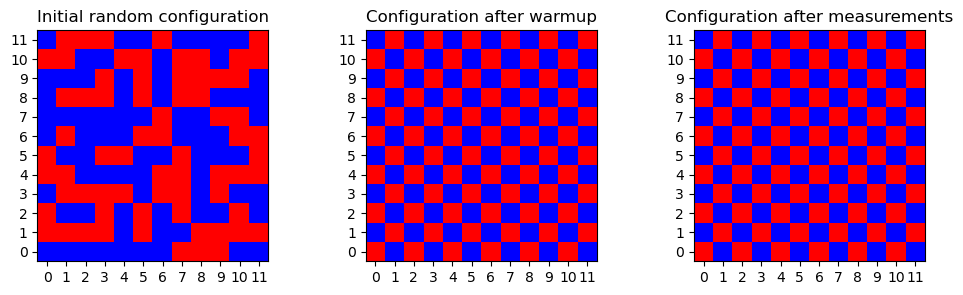

T = 1.00 statistics: 
mag_avg = 0.000247917
mag_error = 0.000120368
stag_mag_avg = 0.999442
stag_mag_error = 0.000136855






####################
##### T = 1.10 #####
####################


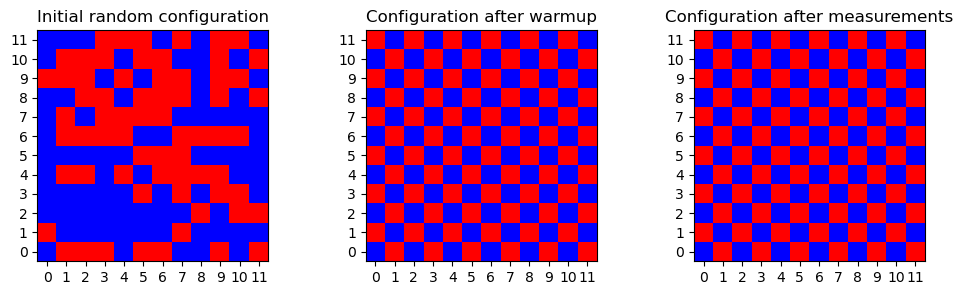

T = 1.10 statistics: 
mag_avg = 0.000111944
mag_error = 0.000197233
stag_mag_avg = 0.998695
stag_mag_error = 0.000216927






####################
##### T = 1.20 #####
####################


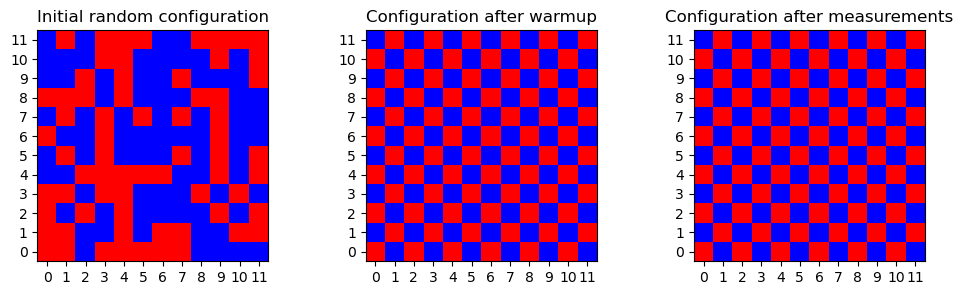

T = 1.20 statistics: 
mag_avg = -0.00015625
mag_error = 0.00021971
stag_mag_avg = 0.996886
stag_mag_error = 0.000376594






####################
##### T = 1.30 #####
####################


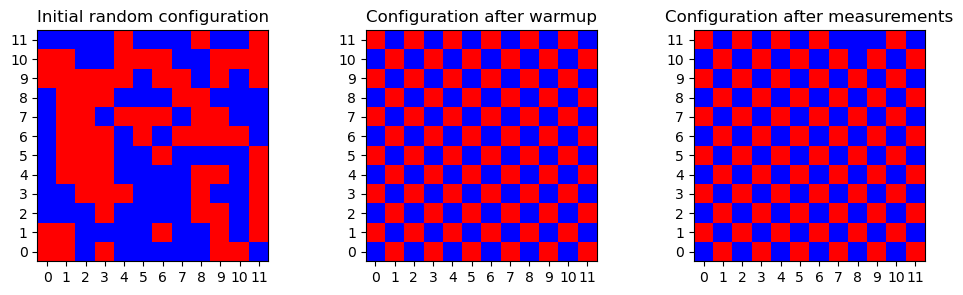

T = 1.30 statistics: 
mag_avg = 4.04167e-05
mag_error = 0.000353711
stag_mag_avg = 0.995499
stag_mag_error = 0.000496543






####################
##### T = 1.40 #####
####################


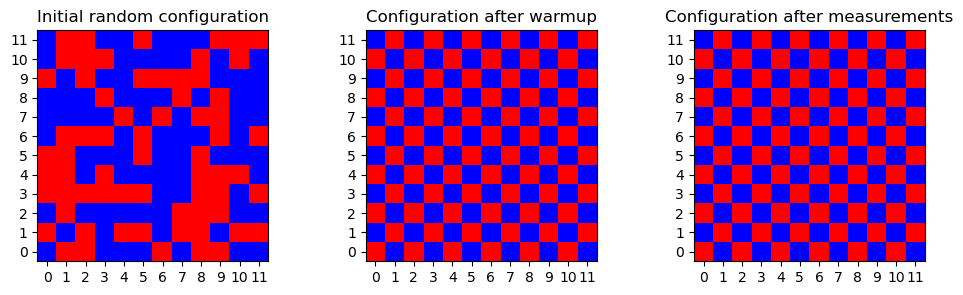

T = 1.40 statistics: 
mag_avg = -0.000519861
mag_error = 0.000455252
stag_mag_avg = 0.991205
stag_mag_error = 0.000683572






####################
##### T = 1.50 #####
####################


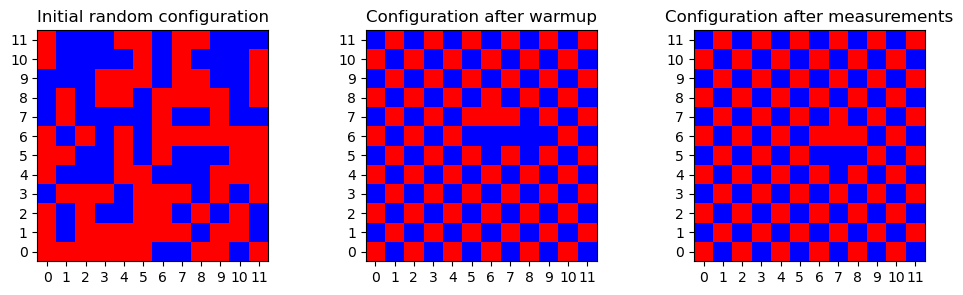

T = 1.50 statistics: 
mag_avg = 0.000720556
mag_error = 0.00055243
stag_mag_avg = 0.984308
stag_mag_error = 0.00101663






####################
##### T = 1.60 #####
####################


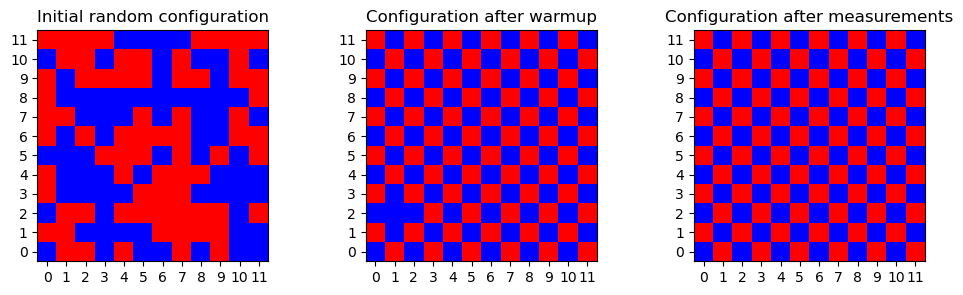

T = 1.60 statistics: 
mag_avg = 0.000435139
mag_error = 0.00055659
stag_mag_avg = 0.978488
stag_mag_error = 0.0013096






####################
##### T = 1.70 #####
####################


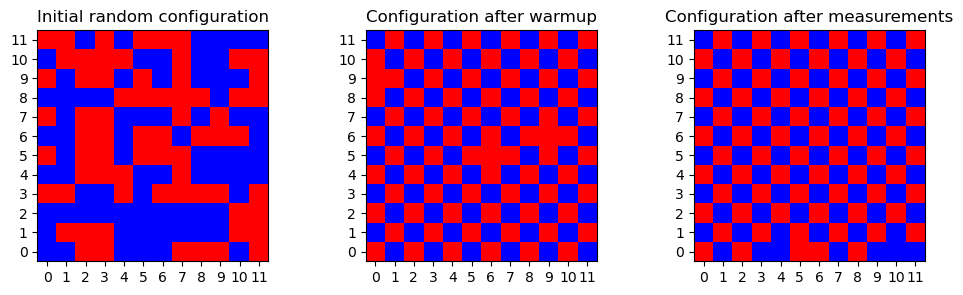

T = 1.70 statistics: 
mag_avg = 7.33333e-05
mag_error = 0.000668539
stag_mag_avg = 0.968245
stag_mag_error = 0.00201924






####################
##### T = 1.80 #####
####################


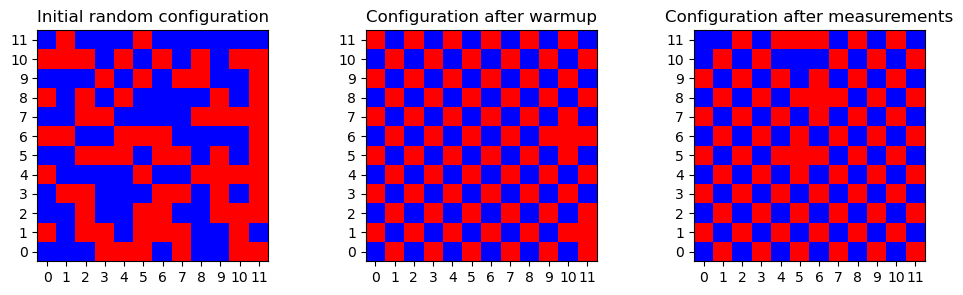

T = 1.80 statistics: 
mag_avg = 0.001085
mag_error = 0.000728774
stag_mag_avg = 0.95217
stag_mag_error = 0.00371723






####################
##### T = 1.90 #####
####################


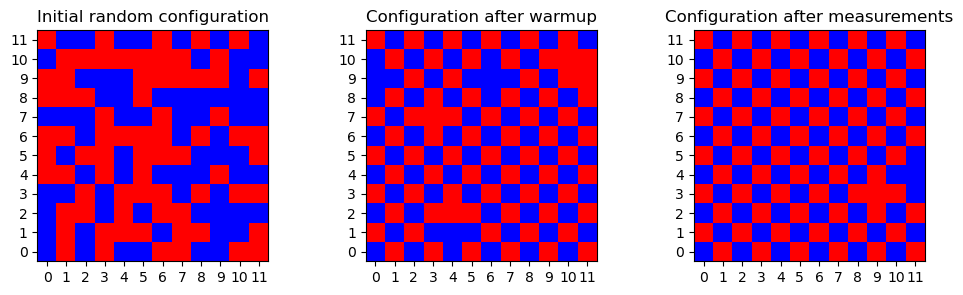

T = 1.90 statistics: 
mag_avg = -0.000436111
mag_error = 0.000896372
stag_mag_avg = 0.946684
stag_mag_error = 0.00307173






####################
##### T = 2.00 #####
####################


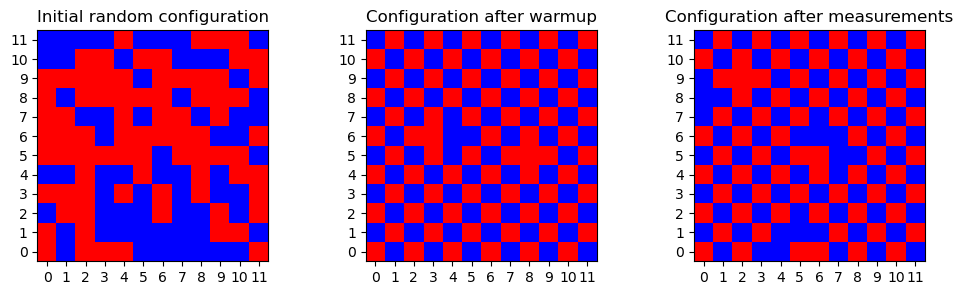

T = 2.00 statistics: 
mag_avg = -0.000546007
mag_error = 0.000533933
stag_mag_avg = 0.910997
stag_mag_error = 0.00376008






####################
##### T = 2.10 #####
####################


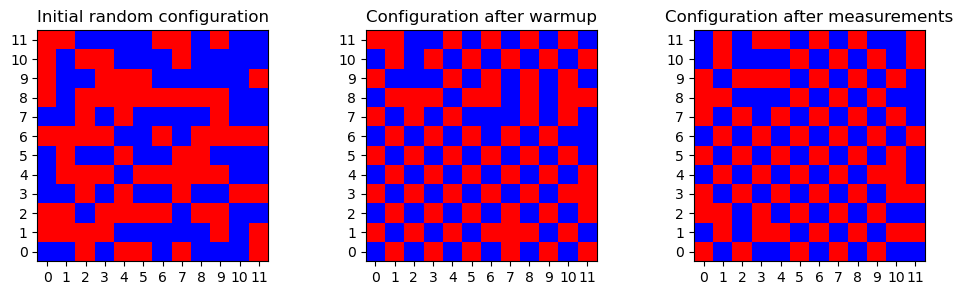

T = 2.10 statistics: 
mag_avg = -0.000521597
mag_error = 0.000492607
stag_mag_avg = 0.881549
stag_mag_error = 0.00453973






####################
##### T = 2.20 #####
####################


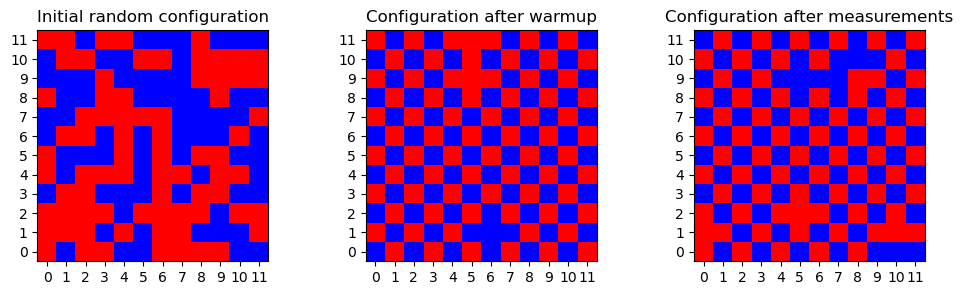

T = 2.20 statistics: 
mag_avg = 0.000304514
mag_error = 0.000552709
stag_mag_avg = 0.799859
stag_mag_error = 0.0119048






####################
##### T = 2.30 #####
####################


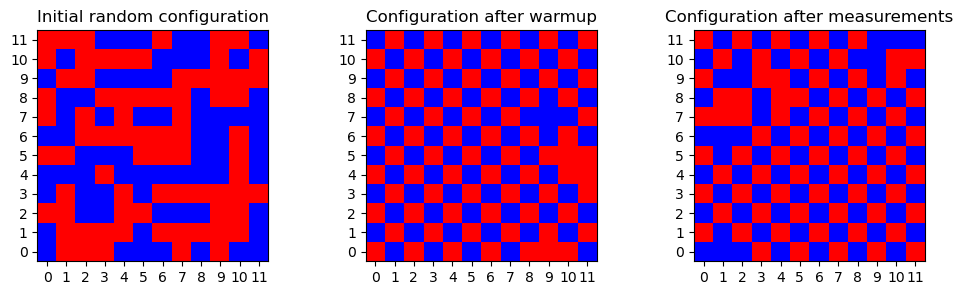

T = 2.30 statistics: 
mag_avg = -6.1875e-05
mag_error = 0.000594208
stag_mag_avg = 0.712772
stag_mag_error = 0.0160627






####################
##### T = 2.40 #####
####################


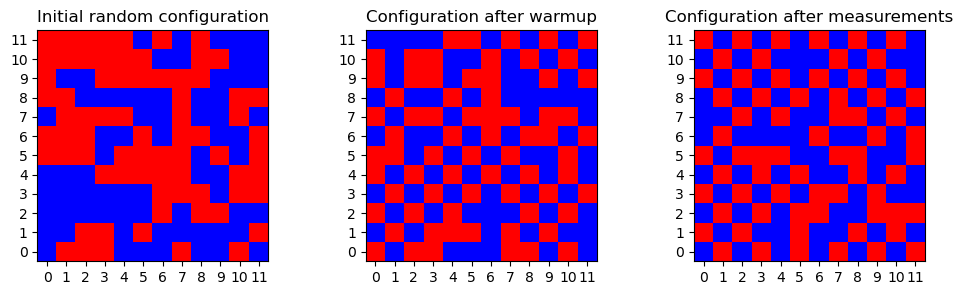

T = 2.40 statistics: 
mag_avg = -8.04167e-05
mag_error = 0.00060921
stag_mag_avg = 0.572207
stag_mag_error = 0.0216585






####################
##### T = 2.50 #####
####################


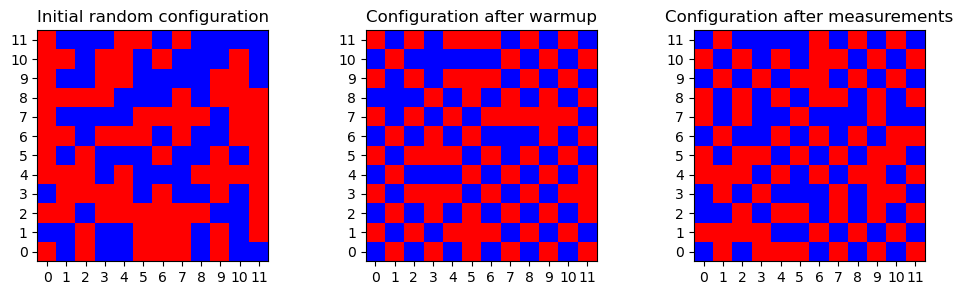

T = 2.50 statistics: 
mag_avg = -0.00029684
mag_error = 0.000686367
stag_mag_avg = 0.491739
stag_mag_error = 0.0171238






####################
##### T = 2.60 #####
####################


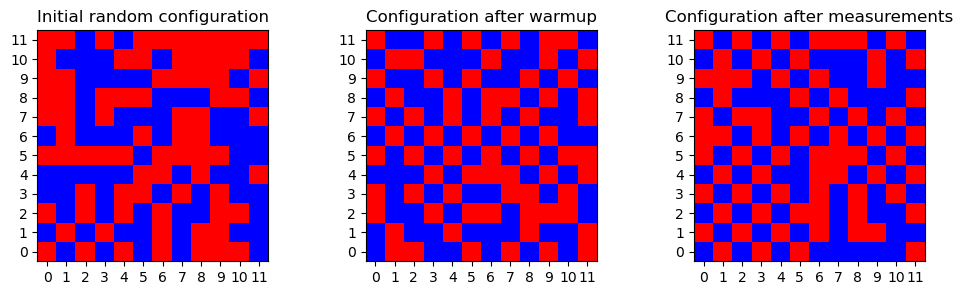

T = 2.60 statistics: 
mag_avg = -0.000474896
mag_error = 0.000597891
stag_mag_avg = 0.410217
stag_mag_error = 0.0172109






####################
##### T = 2.70 #####
####################


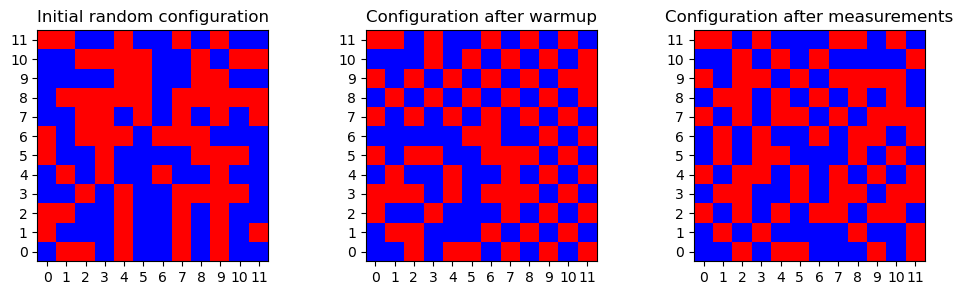

T = 2.70 statistics: 
mag_avg = -7.60764e-05
mag_error = 0.000689931
stag_mag_avg = 0.352064
stag_mag_error = 0.0144657






####################
##### T = 2.80 #####
####################


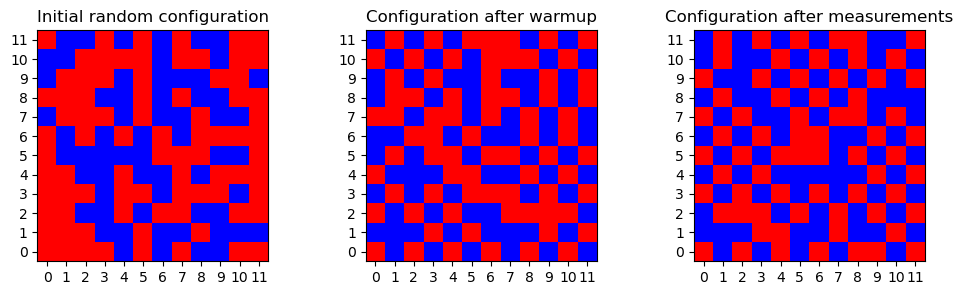

T = 2.80 statistics: 
mag_avg = -0.000646076
mag_error = 0.000730862
stag_mag_avg = 0.269242
stag_mag_error = 0.0115096






####################
##### T = 2.90 #####
####################


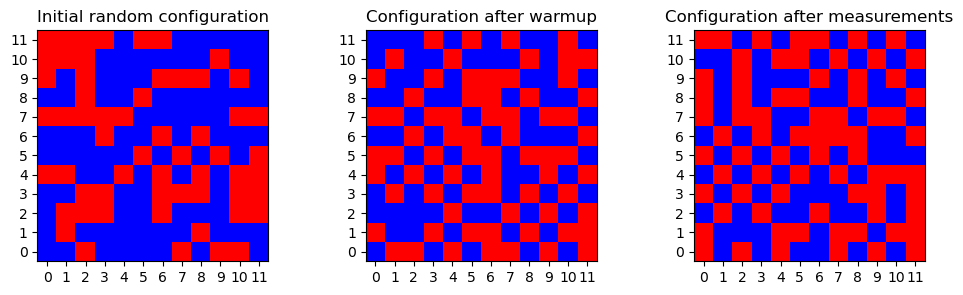

T = 2.90 statistics: 
mag_avg = -0.000409479
mag_error = 0.000741158
stag_mag_avg = 0.25057
stag_mag_error = 0.00996849






####################
##### T = 3.00 #####
####################


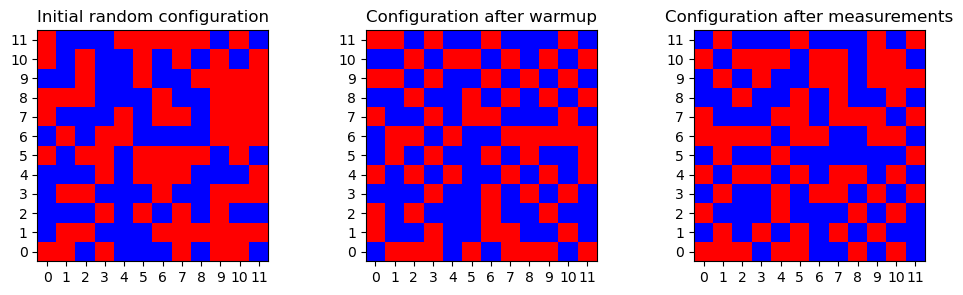

T = 3.00 statistics: 
mag_avg = 0.000743646
mag_error = 0.000639154
stag_mag_avg = 0.218009
stag_mag_error = 0.00786827






####################
##### T = 3.10 #####
####################


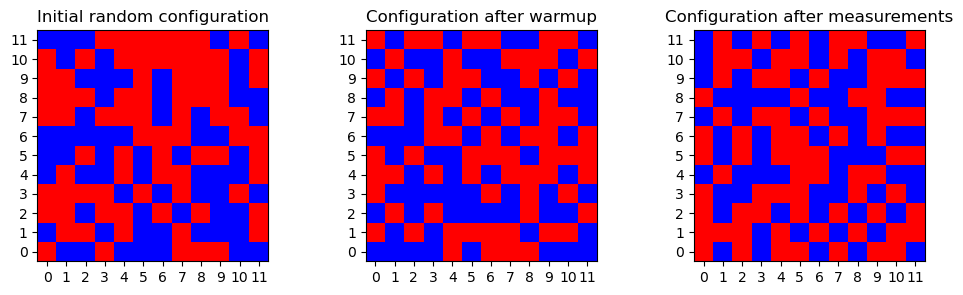

T = 3.10 statistics: 
mag_avg = 0.00147653
mag_error = 0.00133638
stag_mag_avg = 0.19676
stag_mag_error = 0.0115068






####################
##### T = 3.20 #####
####################


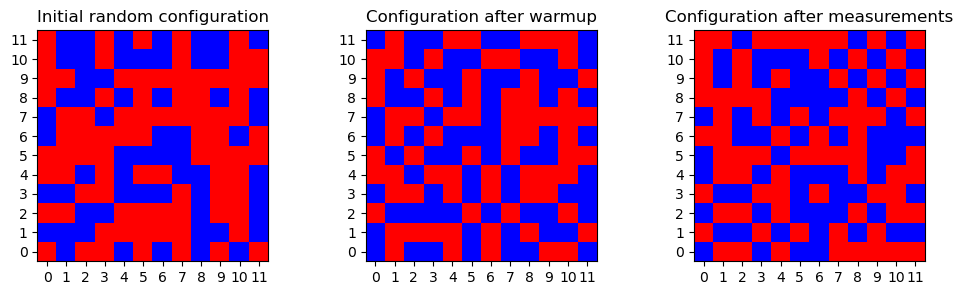

T = 3.20 statistics: 
mag_avg = 0.0012075
mag_error = 0.00145946
stag_mag_avg = 0.209646
stag_mag_error = 0.0103235






####################
##### T = 3.30 #####
####################


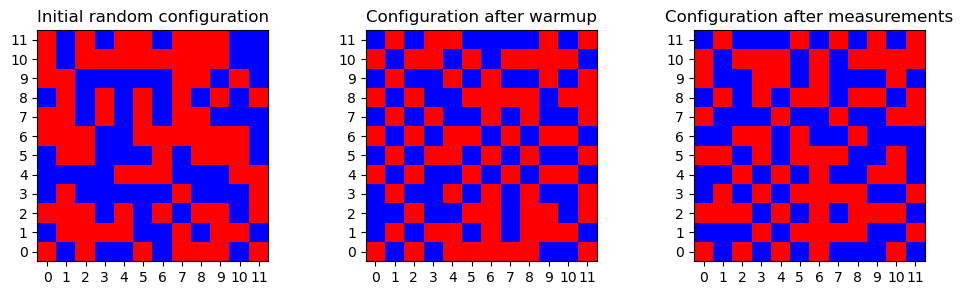

T = 3.30 statistics: 
mag_avg = -0.000802361
mag_error = 0.0014069
stag_mag_avg = 0.203482
stag_mag_error = 0.00922614






####################
##### T = 3.40 #####
####################


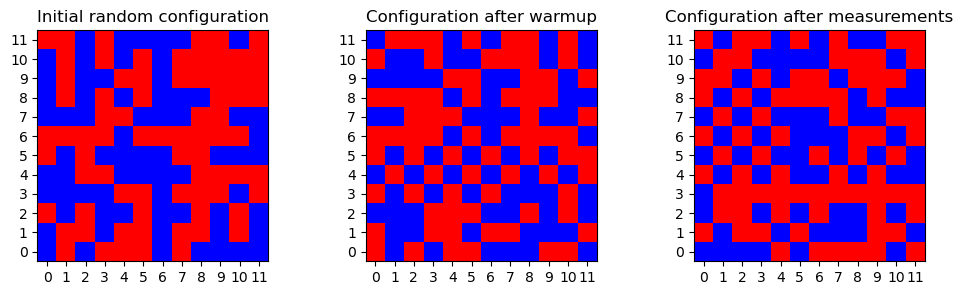

T = 3.40 statistics: 
mag_avg = -0.00231722
mag_error = 0.00166107
stag_mag_avg = 0.177924
stag_mag_error = 0.00866202






####################
##### T = 3.50 #####
####################


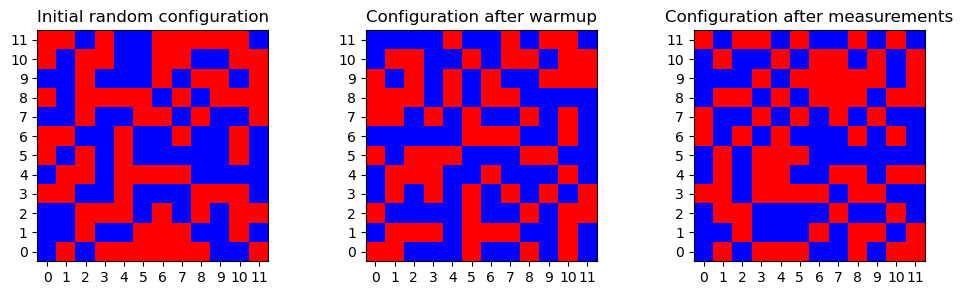

T = 3.50 statistics: 
mag_avg = 0.00192125
mag_error = 0.00171563
stag_mag_avg = 0.172924
stag_mag_error = 0.00894717






####################
##### T = 3.60 #####
####################


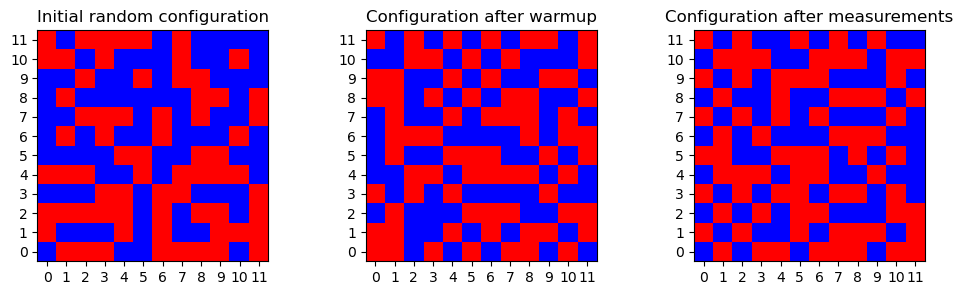

T = 3.60 statistics: 
mag_avg = 0.000681806
mag_error = 0.001517
stag_mag_avg = 0.15351
stag_mag_error = 0.00699081






####################
##### T = 3.70 #####
####################


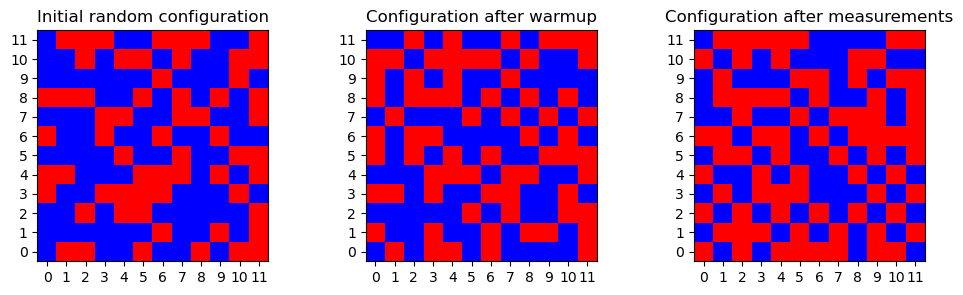

T = 3.70 statistics: 
mag_avg = -0.000723056
mag_error = 0.00144623
stag_mag_avg = 0.158264
stag_mag_error = 0.00814628






####################
##### T = 3.80 #####
####################


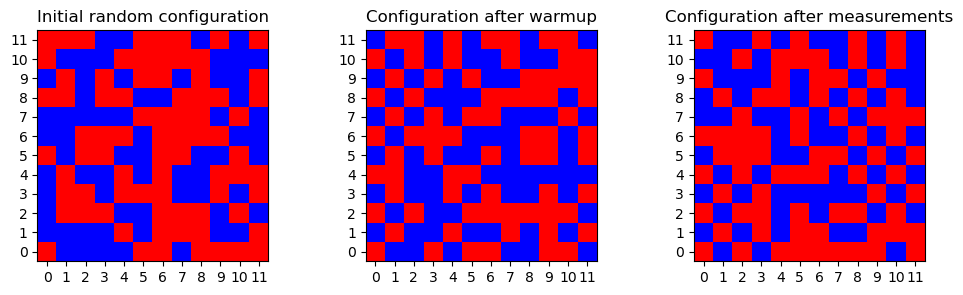

T = 3.80 statistics: 
mag_avg = 0.00141014
mag_error = 0.00156338
stag_mag_avg = 0.145857
stag_mag_error = 0.00675019






####################
##### T = 3.90 #####
####################


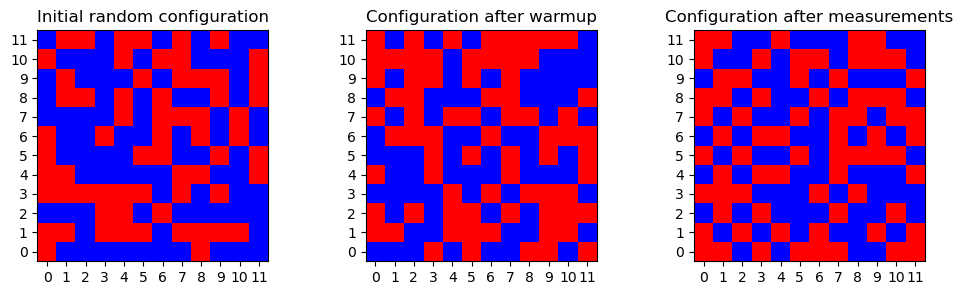

T = 3.90 statistics: 
mag_avg = 0.00318375
mag_error = 0.00179312
stag_mag_avg = 0.151032
stag_mag_error = 0.00675634






####################
##### T = 4.00 #####
####################


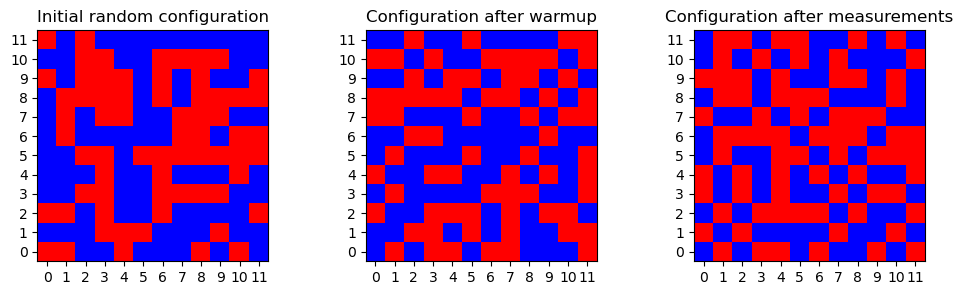

T = 4.00 statistics: 
mag_avg = -0.00168903
mag_error = 0.00181591
stag_mag_avg = 0.12973
stag_mag_error = 0.00559102






####################
##### T = 4.10 #####
####################


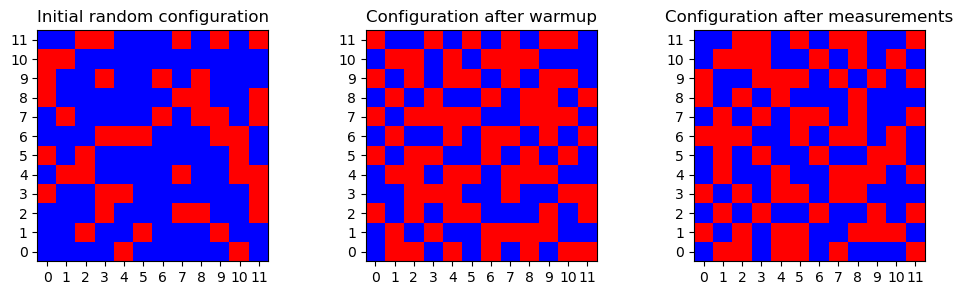

T = 4.10 statistics: 
mag_avg = -0.00334028
mag_error = 0.00148298
stag_mag_avg = 0.144447
stag_mag_error = 0.00611844






####################
##### T = 4.20 #####
####################


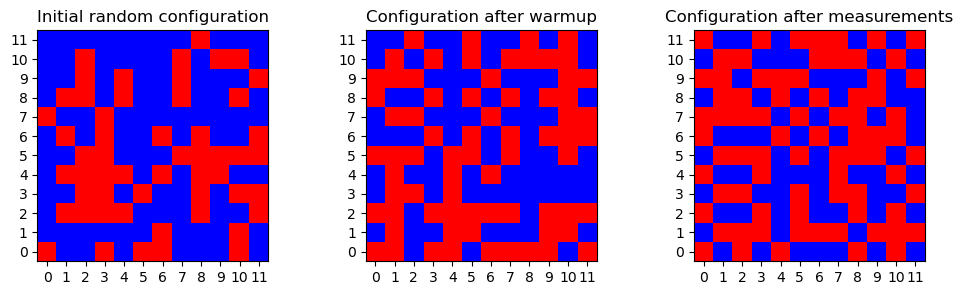

T = 4.20 statistics: 
mag_avg = 0.00195444
mag_error = 0.00156298
stag_mag_avg = 0.139294
stag_mag_error = 0.00705851






####################
##### T = 4.30 #####
####################


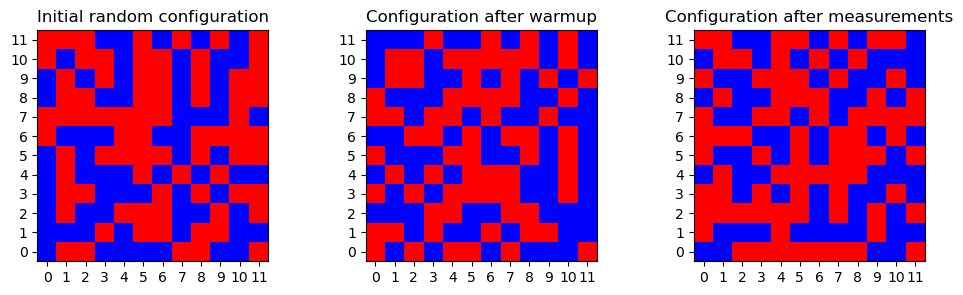

T = 4.30 statistics: 
mag_avg = 0.00116472
mag_error = 0.0016103
stag_mag_avg = 0.136984
stag_mag_error = 0.00605389






####################
##### T = 4.40 #####
####################


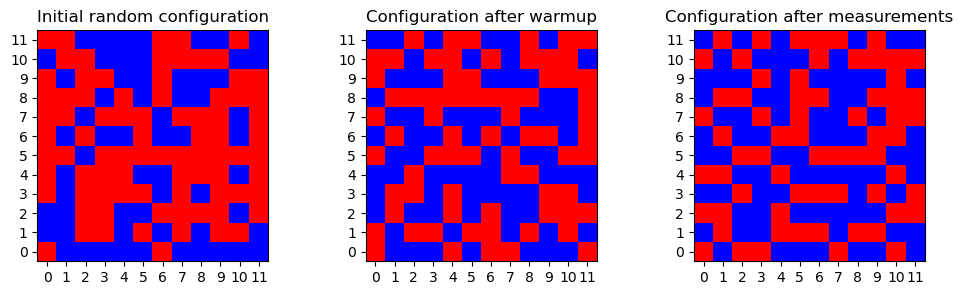

T = 4.40 statistics: 
mag_avg = -0.00261153
mag_error = 0.00179236
stag_mag_avg = 0.125831
stag_mag_error = 0.00502139






####################
##### T = 4.50 #####
####################


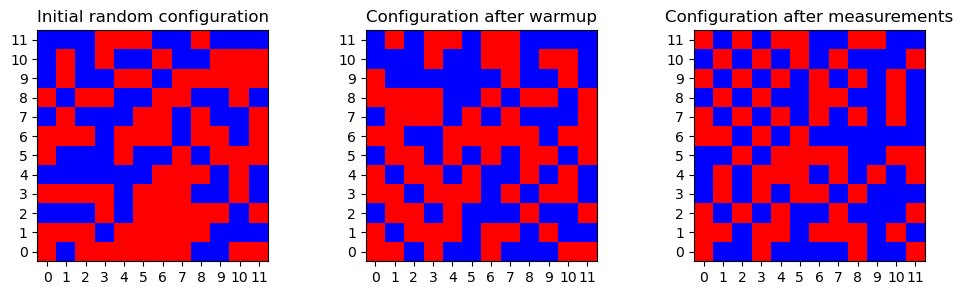

T = 4.50 statistics: 
mag_avg = -0.00063875
mag_error = 0.00157382
stag_mag_avg = 0.12941
stag_mag_error = 0.00516348






####################
##### T = 4.60 #####
####################


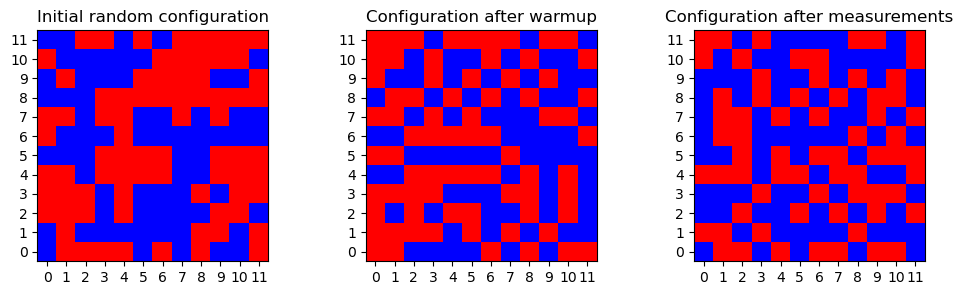

T = 4.60 statistics: 
mag_avg = -0.000196944
mag_error = 0.0017861
stag_mag_avg = 0.12572
stag_mag_error = 0.00468009






####################
##### T = 4.70 #####
####################


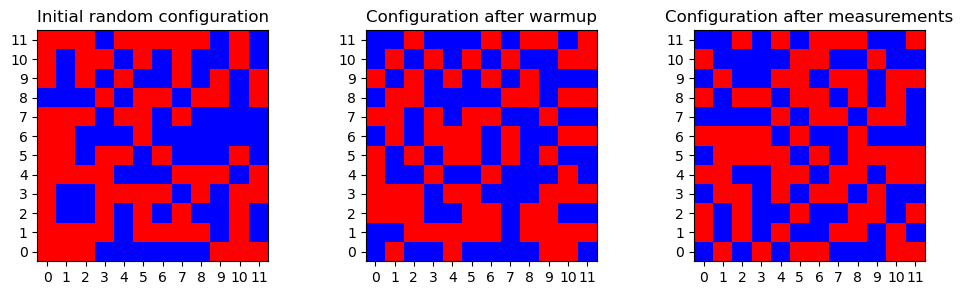

T = 4.70 statistics: 
mag_avg = 0.00207569
mag_error = 0.00172349
stag_mag_avg = 0.115339
stag_mag_error = 0.00409364






####################
##### T = 4.80 #####
####################


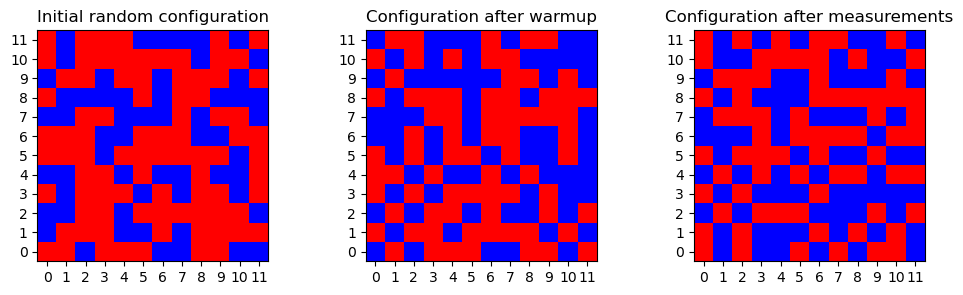

T = 4.80 statistics: 
mag_avg = 0.000402361
mag_error = 0.00207872
stag_mag_avg = 0.112969
stag_mag_error = 0.00432848






####################
##### T = 4.90 #####
####################


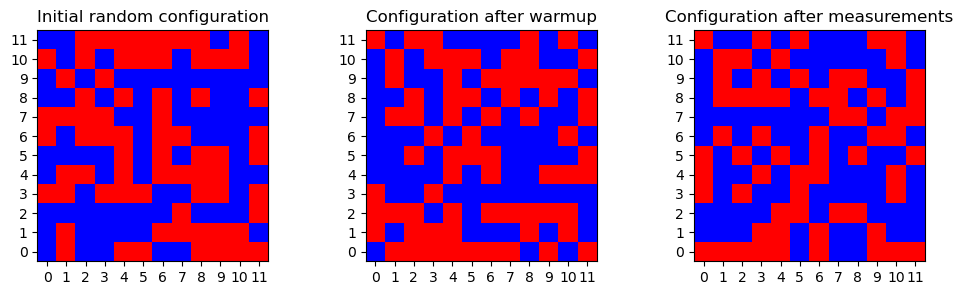

T = 4.90 statistics: 
mag_avg = -0.000475278
mag_error = 0.00173645
stag_mag_avg = 0.113793
stag_mag_error = 0.00413358






####################
##### T = 5.00 #####
####################


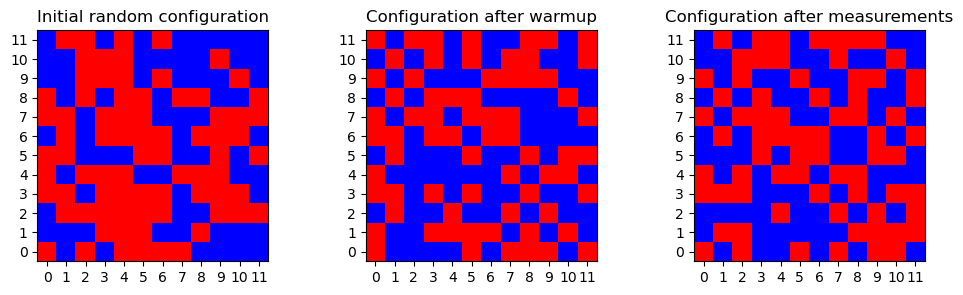

T = 5.00 statistics: 
mag_avg = 0.000575417
mag_error = 0.00179605
stag_mag_avg = 0.118776
stag_mag_error = 0.0039393








In [111]:
J = 1
L = 12
T_min = 1
T_max = 5
N_temps = 41
N_bin = 100
N_warm = 100000
N_meas = 100000
T2_min = 2
T2_max = 3
N_warm_2 = 400000
N_meas_2 = 400000

binned_configurations_array, T_array, m_array, me_array, sm_array, sme_array = simulation(J, L, T_min, T_max, N_temps, N_bin, N_warm, N_meas, T2_min, T2_max, N_warm_2, N_meas_2)

In [112]:
binned_configurations_array.shape

(4100, 145)

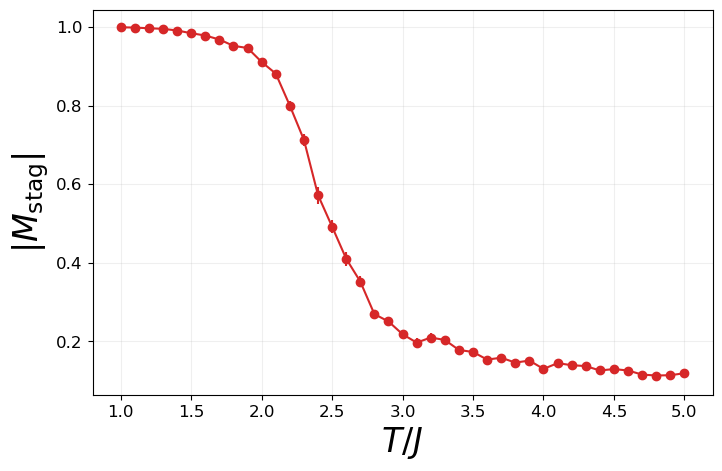

In [113]:
plt.figure(figsize=(8,5))
plt.errorbar(T_array, sm_array, yerr=sme_array, marker='o', linestyle='solid', color='tab:red')
plt.ylabel(r'$|M_{\mathrm{stag}}|$', fontsize=24)
plt.yticks(fontsize=12)
plt.xlabel(r'$T/J$', fontsize=24)
plt.xticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show()

In [114]:
binned_configurations_df = pd.DataFrame(binned_configurations_array)
binned_configurations_df.rename({144:'Temperature'}, axis=1, inplace=True)
binned_configurations_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Temperature
4090,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,5.0
4091,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,5.0
4092,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,5.0
4093,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,5.0
4094,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,5.0
4095,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,5.0
4096,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,5.0
4097,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,5.0
4098,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,5.0
4099,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,5.0
